<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Chapter5 <font></h3>

* コードは、  
  https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_05.ipynb  
  から引用しています。

In [1]:
import os
import warnings

import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from aesara import shared
from causalgraphicalmodels import CausalGraphicalModel
from scipy import stats
from scipy.interpolate import griddata

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
np.random.seed(0)

In [3]:
data = pd.read_csv( "WaffleDivorce.csv", delimiter=";")

In [4]:
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [5]:
def standardize(series):
    """pandas seriesを標準化する"""
    std_series = (series - series.mean())/series.std()
    return std_series

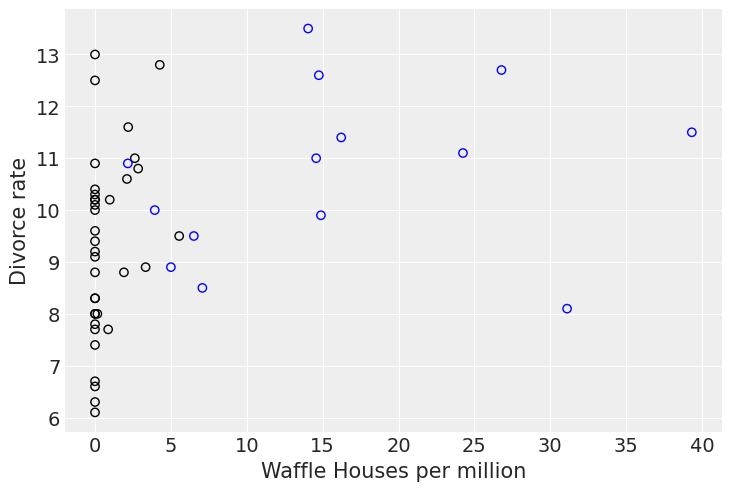

In [6]:
#fig 5.1 欠損した平均
fig, ax = plt.subplots()

# 南部連邦への色の割り当て
colors = {"1": "blue", "0": "black"}

ax.scatter(
    data["WaffleHouses"] / data["Population"],
    data["Divorce"],
    lw=1,
    color=(0,0,0,0),
    edgecolor=data["South"].apply(lambda x: colors[str(x)]),
)

ax.set_xlabel("Waffle Houses per million")
ax.set_ylabel("Divorce rate")

# 離婚率が12.6を超えているか、
# 住民あたりのワッフルハウスが30を超えているstatesだけを取り出す
selection = data[(data["Divorce"]>12.6) | (data["WaffleHouses"]/ data["Population"])>30]

# 各点のラベル
for state, div, ratio in zip(
    selection["Loc"],
    selection["WaffleHouses"] / selection["Population"],
    selection["Divorce"],
):
    ax.annotate(f"{state}", xy=(div, ratio), textcoords="offset points", xytext=(10, -5))
    


Text(0.5, 0, 'Median age marriage')

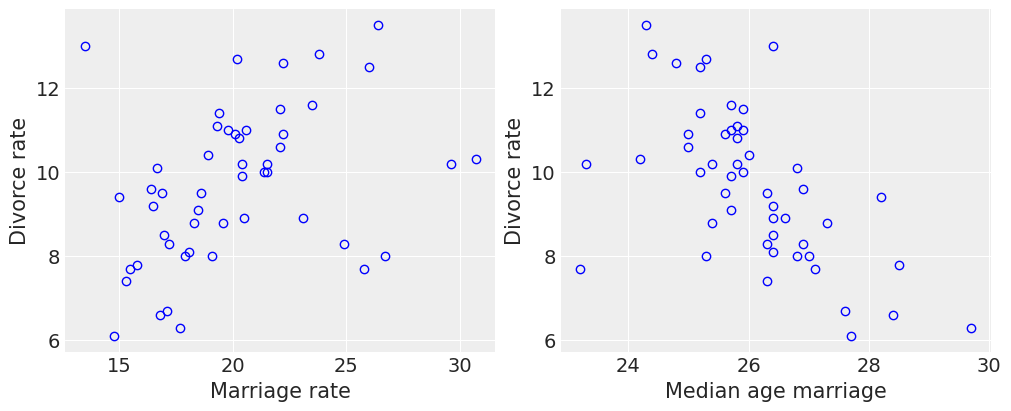

In [7]:
# fig 5.2 欠損した平均と信用区間
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(data["Marriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0),
              edgecolor="b")
ax[0].set_ylabel("Divorce rate")
ax[0].set_xlabel("Marriage rate")

ax[1].scatter(data["MedianAgeMarriage"], data["Divorce"], lw=1, 
              color=(0, 0, 0, 0), edgecolor="b")
ax[1].set_ylabel("Divorce rate")
ax[1].set_xlabel("Median age marriage")

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: 疑似相関</font></h3>

* 左はmarriage rate (元のnotebookはラベルの間違い)

In [8]:
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

In [9]:
data["MedianAgeMarriage"].std()

1.2436303013880823

In [10]:
with pm.Model () as m_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bA * data["MedianAgeMarriage_std"].values)

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_1_trace = pm.sample()

Sampling: [a, bA, divorce_rate_std, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: 設定</font></h3>

* sigmaの事前分布がなぜexp("sigma", 1)なのか。

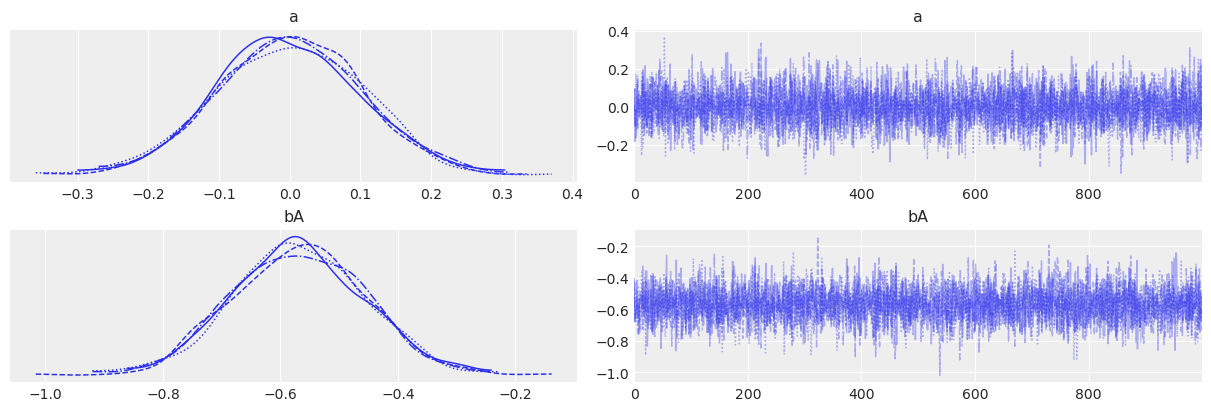

In [11]:
az.plot_trace(m_5_1_trace, var_names=["a", "bA"]);

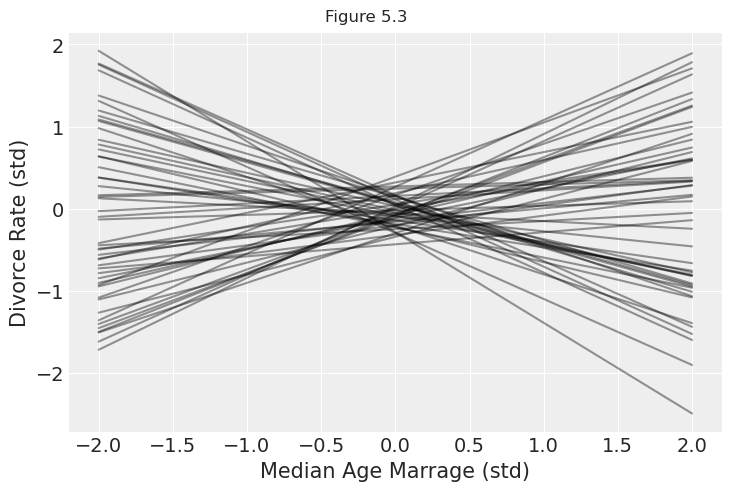

In [18]:
fig, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

prior_samp_a = np.array(az.extract_dataset(prior_samples["prior"])["a"][:50])
prior_samp_bA = np.array(az.extract_dataset(prior_samples["prior"])["bA"][:50])

for a, ba in zip(prior_samp_a, prior_samp_bA):
    y = a + ba * x
    ax.plot(x, y, c = "black", alpha=0.4)

ax.set_xlabel("Median Age Marrage (std)")
ax.set_ylabel("Divorce Rate (std)")
fig.suptitle("Figure 5.3");

In [20]:
m_5_1_trace.posterior["bA"].shape

(4, 1000)

In [22]:
# リンク関数の作成

age_std_seq = np.linspace(-3, 3.2, 30)

# 多くのサンプルがあるのでそれをプロットに使用する
# m_5_1_trace = m_5_1_trace.sel(draw=slice(None. None, 10))
m_5_1_data = az.extract_dataset(m_5_1_trace.posterior)

mu_pred = np.zeros((len(age_std_seq), len(m_5_1_data.sample)))

for i, age_std in enumerate(age_std_seq):
    mu_pred[i] = m_5_1_data["a"] + m_5_1_data["bA"] * age_std

Text(0, 0.5, 'Divorce rate')

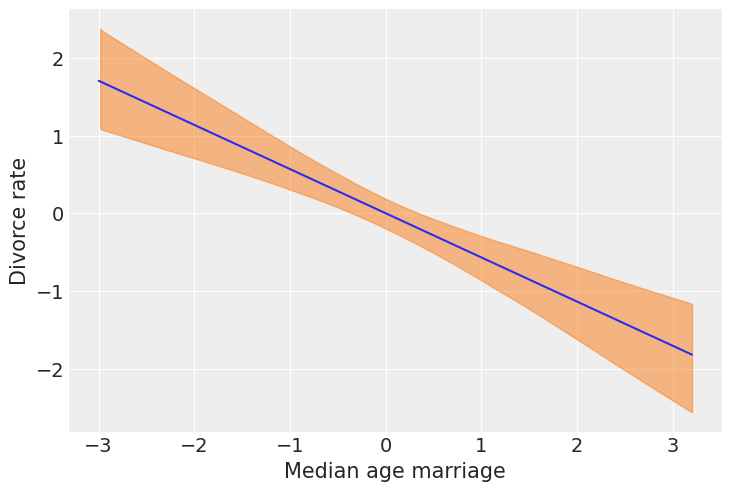

In [23]:
# muの平均をとりプロットする必要がある
# 各xについて30の平均をとる

mu_mean = mu_pred.mean(axis=1)

# 以下はパーセント間隔に相当する
ax = az.plot_hdi(age_std_seq, mu_pred.T)
plt.plot(age_std_seq, mu_mean)
ax.set_xlabel("Median age marriage")
ax.set_ylabel("Divorce rate")

In [25]:
with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bM * data["Marriage_std"].values)

    divorce_rate_std = pm.Normal(
          "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_2_trace = pm.sample()

Sampling: [a, bM, divorce_rate_std, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


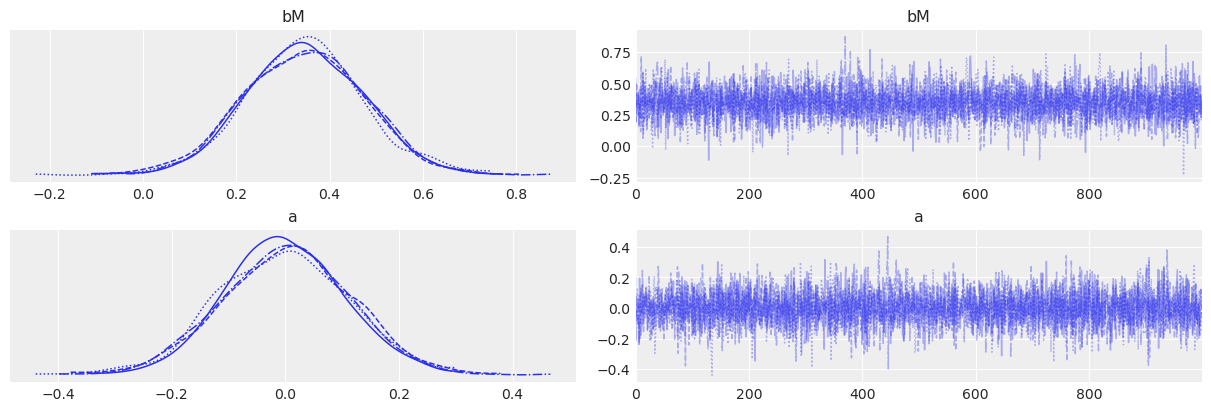

In [26]:
az.plot_trace(m_5_2_trace, var_names=["bM", "a"]);

以下は引用元の和訳

Credit to ksachdeva

著者は、単に双変量回帰のパラメーターの平均を比較するだけでは、どの予測変数が優れているかを判断することはできないと提案しています。なぜなら変数は独立しているか、相関しているか、あるいは互いを相殺しているかもしれません。

では、どのように理解すれば良いのでしょうか？

著者は、ここで因果関係を考える必要があるかもしれないと説明しています。

いくつかの興味深い仮定（あるいは推論）があります：

a) 年齢が離婚率に直接影響を与える可能性がある、ということは、人々がパートナーとの適合性を失うかもしれません。

b) 結婚率は明らかな理由から離婚率に直接影響を与える可能性があります（結婚が増えると、離婚も増える可能性があるため）。

c) 最後に、年齢が結婚率に影響を与える可能性があるのは、若い人がもっと多いからです。

上記を別の方法で表す方法もあります：

A -> D

M -> D

A -> M

そして、別の方法はDAG（有向非巡回グラフ）を使用することです。

C:\Users\satyk\anaconda3\envs\stat-rethink2-pymc_v4\lib\site-packages\IPython\core\events.py:93: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
C:\Users\satyk\anaconda3\envs\stat-rethink2-pymc_v4\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


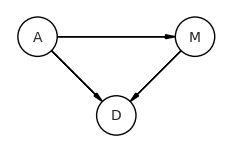

In [29]:
dag5_1 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"),
                                                            ("M", "D")])
pgm = daft.PGM()
coordinates = {"A": (0,0), "D": (1,1), "M":(2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

上記のDAGは、AがDに直接および間接的に影響を与えることを明示的に示しています（つまり、Mを介して影響を与えます）。

著者が「総合的な影響」を使用したことは、AからDへのすべての経路を考慮に入れる必要があることを意味します。

仲介（MEDIATION） - Aが直接的にDに影響を与えなかった場合、代わりにMを介して影響を与えたとしましょう。このタイプの関係は「仲介」と呼ばれます。

著者はここで多くの興味深い質問を提起しています。彼は、結婚率に直接的な影響があるのか、それとも結婚時の年齢が両者を駆動し、結婚率と離婚率の間に見かけの相関関係を作り出すのかという点について尋ねています。

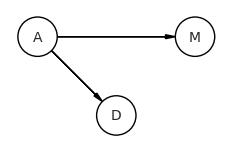

In [35]:
# Note：第二のDAGを描画するための明示的なコードセクションはありませんが、
# 図は教科書に表示されており、それを描画することもできます。

dag5_2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2,0)}
for node in dag5_2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_2.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

因果グラフィカルモデルによって示唆される共同確率分布を取得することができます。

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: 設定</font></h3>

* coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}は、辞書（dictionary）として変数を定義しています。辞書は、キー（"A"、"D"、"M"など）とそれに対応する値（タプル（tuple））とのペアを格納するデータ構造です。この場合、各キーに対応する値は座標を表しています。

In [36]:
print(dag5_2.get_distribution())

P(A)P(D|A)P(M|A)


In [37]:
dag5_2.get_all_independence_relationships()

[('M', 'D', {'A'})]

In [45]:
DMA_dag2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A","M")])
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] !=s[0] or t[1] !=s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t !=s
    ):
        print(s)

('M', 'D', {'A'})
